In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext kedro.extras.extensions.ipython
%reload_kedro

The kedro.extras.extensions.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.extras.extensions.ipython


In [3]:
from dl4thermo.extras.utils.cosmo_calculate import get_cosmobase_df
from dl4thermo.extras.kedro_datasets.checkpoint_dataset import concat_partitioned_dfs
from dl4thermo.extras.utils.plotting import parity_plot
from dl4thermo.extras.utils.metrics import calculate_metrics
from dl4thermo.extras.utils.molecular_fingerprints import _canonicalize_smiles
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import spearmanr, linregress
from scipy.interpolate import griddata
import seaborn as sns
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem.Descriptors import ExactMolWt

In [9]:
pure = catalog.load("dortmund_base_pure_component_filtered")

2023-03-16 17:49:16,129 - kedro.io.data_catalog - INFO - Loading data from 'dortmund_base_pure_component_filtered' (ParquetDataSet)...


## Intersection of COSMObase and Dortmund

In [30]:
all_cosmo.columns

Index(['uniqueCode12', 'smiles', 'casNumber', 'compoundID', 'compoundName'], dtype='object')

In [17]:
pure["smiles_1"].nunique()

10136

In [16]:
cosmo_smiles = set(all_cosmo["smiles"])
dortmund_smiles = set(pure["smiles_1"])
inti = cosmo_smiles.intersection(dortmund_smiles)
print("Number of molecules in Dortmund and COSMObase: ", len(inti))

Number of molecules in Dortmund and COSMObase:  3459


In [32]:
dataset_sizes = pure[
    pure["smiles_1"].isin(list(inti))
]["DEN"].notnull().groupby(pure["smiles_1"]).sum()
already_available = dataset_sizes[dataset_sizes>0].shape[0]
not_available = dataset_sizes[dataset_sizes==0].shape[0]
print(f"{not_available}/{len(dataset_sizes)} COSMO molecules were not available in Dortmund")

2036/3459 COSMO molecules were not available in Dortmund


## Analysis of vapor pressure and density 

In [5]:
cosmo_partitions = catalog.load("cosmo_rs_results")
cosmo_df = concat_partitioned_dfs(cosmo_partitions)

2023-03-13 23:50:09,128 - kedro.io.data_catalog - INFO - Loading data from 'cosmo_rs_results' (CheckPointDataSet)...


In [6]:
has_density =  cosmo_df["Density[g/mol]"].notnull() | cosmo_df["ExpDensity[g/mol]"].notnull()
has_pressure = cosmo_df["PVtot[bar]"].notnull()
has_data = has_pressure & has_density
has_data.value_counts() / len(cosmo_df)

True     0.909091
False    0.090909
dtype: float64

~90% of COSMO-RS data has both density and vapor pressure data.

In [4]:
pure = catalog.load("dortmund_base_pure_component_filtered")
pure_with_density = pure[~pure["DEN"].isna()]

2023-03-13 23:49:56,586 - kedro.io.data_catalog - INFO - Loading data from 'dortmund_base_pure_component_filtered' (ParquetDataSet)...


In [143]:
len(pure_with_density.smiles_1.unique())

2842

In [144]:
cosmo_df_with_density = cosmo_df[has_density]

In [145]:
cosmo_smiles = set(cosmo_df_with_density.smiles)
dortmund_smiles = set(pure_with_density.smiles_1)
inter = cosmo_smiles.intersection(dortmund_smiles)
print(f"Number of compounds in COSMO-RS and Dortmund: {len(inter)}")

Number of compounds in COSMO-RS and Dortmund: 306


In [146]:
cosmo_df.columns

Index(['compoundID', 'compoundName', 'casNumber', 'smiles', 'uniqueCode12',
       'Temperature[K]', 'Density[g/mol]', 'ExpDensity[g/mol]', 'PVtot[bar]',
       'Dipole[Debye]', 'DipoleX[Debye]', 'DipoleY[Debye]', 'DipoleZ[Debye]',
       'sigma_moment_1', 'sigma_moment_2', 'sigma_moment_3', 'sigma_moment_4',
       'sigma_moment_5', 'sigma_moment_6', 'Unnamed: 0', 'Unnamed: 16',
       'Unnamed: 15'],
      dtype='object')

### Vapor pressure error of cosmo

In [147]:
scores_list = []
for smiles in tqdm(inter):
    example_dortmund = pure[pure.smiles_1 == smiles].dropna(subset=["P"])
    example_cosmo = cosmo_df[cosmo_df.smiles == smiles].dropna(subset=["PVtot[bar]"])
    exp_psat = example_dortmund[example_dortmund["DEN"].isna()]
    temps = exp_psat["T"]
    yhat = np.interp(
        temps, 
        example_cosmo['Temperature[K]'],
        example_cosmo["PVtot[bar]"]*100
    )
    y = exp_psat["P"]
    if len(y) > 2 and len(y.unique())>1 and not np.isnan(yhat).any():
        current_scores = calculate_metrics(
            y, yhat, scores=["mae", "spearman", "mape", "r2"]
        )
        current_scores.update({
            "smiles": smiles,
            "min_pressure": y.min(),
            "max_pressure": y.max(),
        })
        scores_list.append(current_scores)

100%|█████████████████████████████████████████████████████████████████████████████| 306/306 [00:03<00:00, 78.95it/s]


In [148]:
scores_df = pd.DataFrame(scores_list)

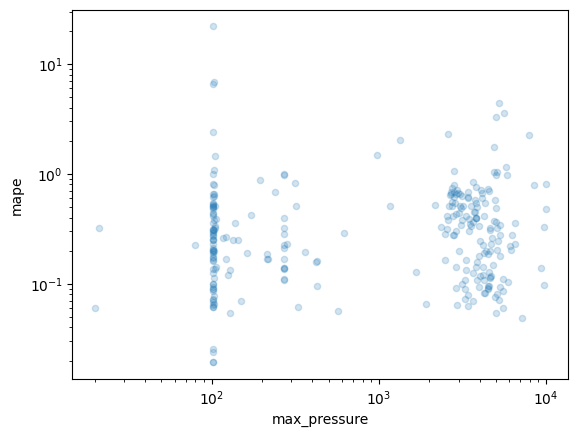

In [149]:
fig, ax = plt.subplots(1)
scores_df[scores_df["max_pressure"]<1e4].plot(x="max_pressure", y="mape", kind="scatter", ax=ax, alpha=0.2)
ax.set_yscale('log')
ax.set_xscale('log')

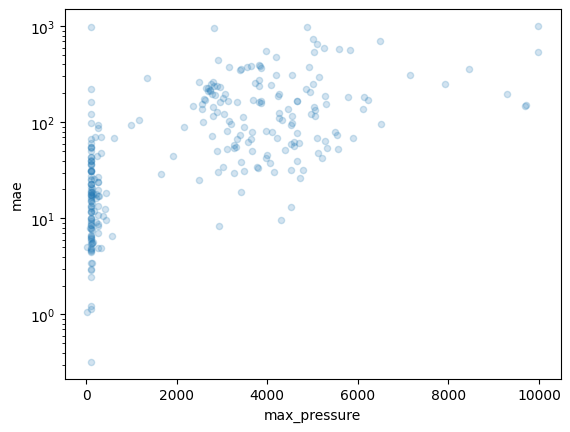

In [150]:
fig, ax = plt.subplots(1)
scores_df[scores_df["max_pressure"]<1e4].plot(x="max_pressure", y="mae", kind="scatter", ax=ax, alpha=0.2)
ax.set_yscale('log')

<Axes: xlabel='max_pressure', ylabel='r2'>

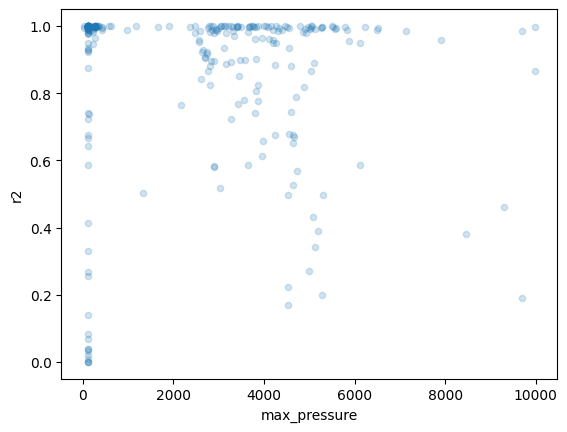

In [151]:
fig, ax = plt.subplots(1)
scores_df[scores_df["max_pressure"]<1e4].plot(x="max_pressure", y="r2", kind="scatter", ax=ax, alpha=0.2)

<Axes: >

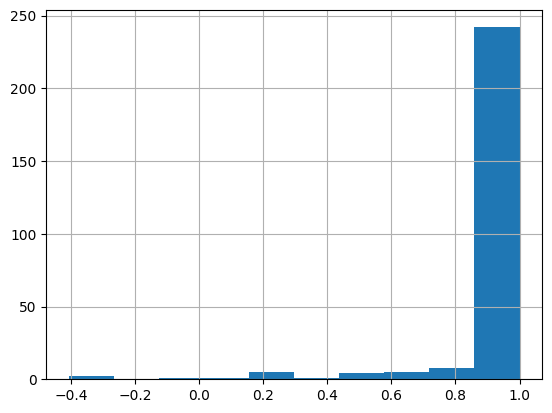

In [152]:
scores_df["spearman"].hist()

In [153]:
scores_df.describe()

,mae,spearman,mape,r2,min_pressure,max_pressure
count,272.000000,269.000000,272.000000,272.000000,272.000000,272.000000
mean,122.323824,0.932140,0.536152,0.865826,36.040824,2420.803647
std,171.699707,0.191079,1.500000,0.248049,261.352334,2319.109324
min,0.320345,-0.406702,0.019280,0.000000,10.003000,20.065000
25%,17.555569,0.975063,0.133273,0.880381,10.310000,104.002750
50%,55.380193,0.992688,0.280340,0.989442,10.666000,2729.750000
75%,164.108698,0.997379,0.512755,0.998295,13.092500,4160.000000
max,1007.857894,1.000000,21.994138,1.000000,4306.310000,9979.300000


### Density error of cosmo 

In [154]:
scores_list = []
for smiles in tqdm(inter):
    example_cosmo = cosmo_df[cosmo_df.smiles == smiles].dropna(subset=["PVtot[bar]"])
    example_cosmo["P"] = example_cosmo["PVtot[bar]"]*100
    example_cosmo["T"] = example_cosmo["Temperature[K]"]
    example_cosmo["DEN"] = example_cosmo["ExpDensity[g/mol]"].combine_first(
        example_cosmo["Density[g/mol]"]
    )
    example_cosmo["DEN"] *= 1e3 # Convert to kg/m^3
    example_cosmo = example_cosmo.dropna(subset="DEN")
    example_dortmund = pure[pure.smiles_1 == smiles].dropna(subset=["P"])
    exp_with_density = example_dortmund[example_dortmund["DEN"].notnull()]
    mins = example_cosmo[["T", "P"]].min()
    maxes = example_cosmo[["T", "P"]].max()
    exp_data = exp_with_density[["T", "P"]].clip(mins, maxes, axis=1)
    yhat =  griddata(
        example_cosmo[["T", "P"]].to_numpy(),
        example_cosmo["DEN"].to_numpy(),
        exp_data.to_numpy(),
        method="nearest",
    )
    y = exp_with_density["DEN"]
    if len(y) > 2 and len(y.unique())>1 and not np.isnan(yhat).any():
        current_scores = calculate_metrics(
            y, yhat, scores=["mae", "spearman", "mape", "r2"]
        )
        current_scores.update({
            "smiles": smiles,
            "min_density": y.min(),
            "max_density": y.max(),
        })
        scores_list.append(current_scores)

100%|█████████████████████████████████████████████████████████████████████████████| 306/306 [00:04<00:00, 63.81it/s]


In [155]:
scores_df = pd.DataFrame(scores_list)
scores_df.sort_values("spearman", ascending=True).head(20)

,mae,spearman,mape,r2,smiles,min_density,max_density
120,65.207560,-0.353553,0.038160,0.049738,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,1651.900,1739.80
235,43.471992,-0.317237,0.049627,0.212901,CCCCCl,788.326,906.30
121,58.842198,-0.124507,0.068640,0.013514,Cc1ccccc1,778.000,948.22
88,21.613851,-0.057299,0.026943,0.001878,CC(C)=O,744.615,889.30
125,29.846986,-0.050805,0.046407,0.000626,CCCCC(C)C,598.000,679.38
102,34.439655,0.041927,0.050939,0.018618,CCCCCCC,593.120,758.00
24,19.543513,0.050577,0.029842,0.019412,CCCCCC,557.103,737.00
234,49.537167,0.053452,0.048258,0.001804,Fc1ccccc1,950.610,1086.90
136,14.891481,0.056542,0.023239,0.008193,CCCC(C)C,609.000,672.00
154,70.130754,0.108143,0.091079,0.004917,CC#N,693.800,798.40


In [ ]:
score

<Axes: >

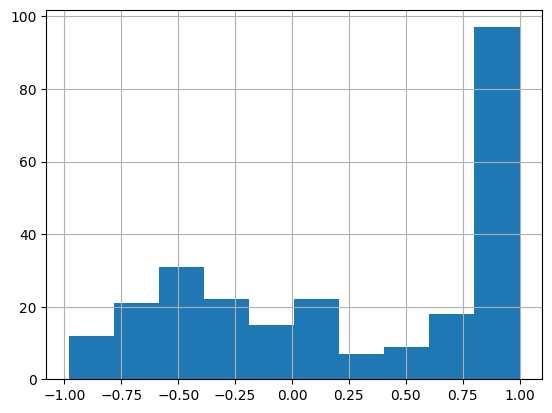

In [134]:
scores_df["spearman"].hist()

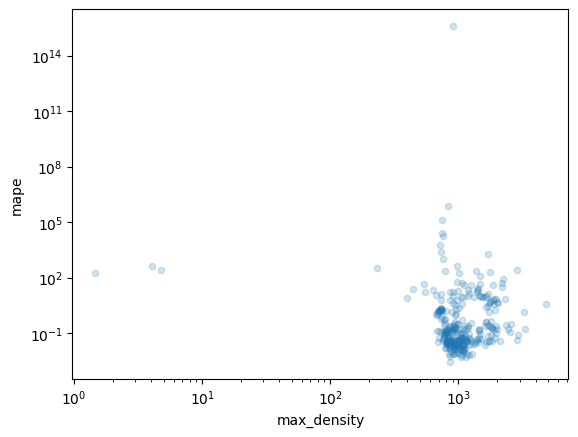

In [133]:
fig, ax = plt.subplots(1)
scores_df.plot(x="max_density", y="mape", kind="scatter", ax=ax, alpha=0.2)
ax.set_yscale('log')
ax.set_xscale('log')

## Visualization 

In [162]:
def EQ101(T, A, B, C=0.0, D=0.0, E=0.0, order=0):
    r'''DIPPR Equation # 101. Used in calculating vapor pressure, sublimation
    pressure, and liquid viscosity.
    All 5 parameters are required. E is often an integer. As the model is
    exponential, a sufficiently high temperature will cause an OverflowError.
    A negative temperature (or just low, if fit poorly) may cause a math domain
    error.

    .. math::
        Y = \exp\left(A + \frac{B}{T} + C\cdot \ln T + D \cdot T^E\right)

    Parameters
    ----------
    T : float
        Temperature, [K]
    A-E : float
        Parameter for the equation; chemical and property specific [-]
    order : int, optional
        Order of the calculation. 0 for the calculation of the result itself;
        for `n`, the `nth` derivative of the property is returned. No
        other integrals or derivatives are implemented, and an exception will
        be raised if any other order is given.

    Returns
    -------
    Y : float
        Property [constant-specific]

    Notes
    -----
    This function is not integrable for either dT or Y/T dT.

    .. math::
        \frac{d Y}{dT} = \left(- \frac{B}{T^{2}} + \frac{C}{T}
        + \frac{D E T^{E}}{T}\right) e^{A + \frac{B}{T}
        + C \log{\left(T \right)} + D T^{E}}

    .. math::
        \frac{d^2 Y}{dT^2} = \frac{\left(\frac{2 B}{T} - C + D E^{2} T^{E}
        - D E T^{E} + \left(- \frac{B}{T} + C + D E T^{E}\right)^{2}\right)
        e^{A + \frac{B}{T} + C \log{\left(T \right)} + D T^{E}}}{T^{2}}

    .. math::
        \frac{d^3 Y}{dT^3} = \frac{\left(- \frac{6 B}{T} + 2 C + D E^{3} T^{E}
        - 3 D E^{2} T^{E} + 2 D E T^{E} + \left(- \frac{B}{T} + C
        + D E T^{E}\right)^{3} + 3 \left(- \frac{B}{T} + C + D E T^{E}\right)
        \left(\frac{2 B}{T} - C + D E^{2} T^{E} - D E T^{E}\right)\right)
        e^{A + \frac{B}{T} + C \log{\left(T \right)} + D T^{E}}}{T^{3}}

    Examples
    --------
    Water vapor pressure; DIPPR coefficients normally listed in Pa.

    >>> EQ101(300, 73.649, -7258.2, -7.3037, 4.1653E-6, 2)
    3537.44834545549

    References
    ----------
    .. [1] Design Institute for Physical Properties, 1996. DIPPR Project 801
       DIPPR/AIChE
    '''
    T_inv = 1.0/T
    try:
        T_E = T**E
    except:
        T_E = 1e250
    expr = np.exp(A + B*T_inv + C*trunc_log(T) + D*T_E)
    if order == 0:
        return expr
    elif order == 1:
        return T_inv*expr*(-B*T_inv + C + D*E*T_E)
    elif order == 2:
        x0 = (-B*T_inv + C + D*E*T_E)
        return expr*(2.0*B*T_inv - C + D*E*T_E*(E - 1.0) + x0*x0)*T_inv*T_inv
    elif order == 3:
        E2 = E*E
        E3 = E2*E
        x0 = (-B*T_inv + C + D*E*T_E)
        return expr*(-6.0*B*T_inv + 2.0*C + D*E3*T_E - 3*D*E2*T_E + 2.0*D*E*T_E
                     + x0*x0*x0
                     + 3.0*(-B*T_inv + C + D*E*T_E)*(2.0*B*T_inv - C + D*E2*T_E - D*E*T_E))*T_inv*T_inv*T_inv
    else:
        raise ValueError(order_not_found_pos_only_msg)

Text(0.5, 0, '$\\rho$ / kg/m³')

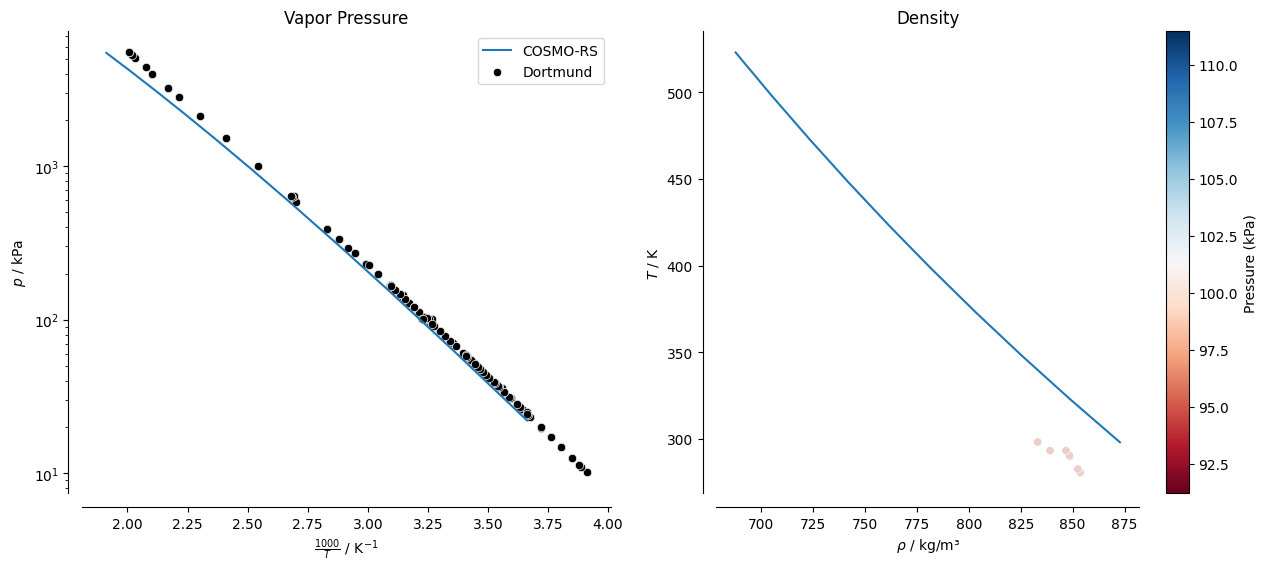

In [21]:
# compound_idx = 30
smiles = "CCS"
# example_dortmund = pure[pure.smiles_1 == list(inter)[compound_idx]]
# example_cosmo = cosmo_df[cosmo_df.smiles == list(inter)[compound_idx]]
example_dortmund = pure[pure.smiles_1 == smiles]
example_cosmo = cosmo_df[cosmo_df.smiles == smiles]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))


# Vapor pressure

sns.lineplot(
    y=example_cosmo['PVtot[bar]']*100, # Convert to kPa 
    x=1000./example_cosmo['Temperature[K]'], 
    label="COSMO-RS",
    ax=ax[0],
)
pvap_data = example_dortmund[example_dortmund["DEN"].isna()]
sns.scatterplot(
    y=pvap_data['P'], 
    x=1000./pvap_data['T'], 
    label="Dortmund",
    ax=ax[0],
    color="k",
)
ax[0].set_title("Vapor Pressure")
ax[0].set_yscale("log")
ax[0].set_xlabel(r"$\frac{1000}{T}$ / K$^{-1}$")
ax[0].set_ylabel(r"$p$ / kPa")
ax[0].legend()
sns.despine(offset=10)


# Desnity
sns.lineplot(
    # Actually g/cm3
    x=example_cosmo['Density[g/mol]']*1e3,
    y=example_cosmo['Temperature[K]'], 
    label="COSMO-RS",
    ax=ax[1],
)
sns.scatterplot(
    data=example_dortmund,
    x='DEN',
    y='T',
    hue='P',
    label="Dortmund",
    ax=ax[1],
    # color="k",
)
example_dortmund_den = example_dortmund[example_dortmund['DEN'].notnull()]
norm = plt.Normalize(example_dortmund_den['P'].min(), example_dortmund_den['P'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax[1].set_title("Density")
ax[1].get_legend().remove()
ax[1].figure.colorbar(sm, label="Pressure (kPa)")
ax[1].set_ylabel(r"$T$ / K")
ax[1].set_xlabel(r"$\rho$ / kg/m³")


In [159]:
example_dortmund[

,Component,#DDB,T,P,Type,DEN,cas_number_1,name_1,alternative_name_1,smiles_1,status_1
1035,Toluene,161,423.15,276.0,Experimental Data,NaN,108-88-3,Toluene,Methylbenzene,Cc1ccccc1,Include
1036,Toluene,161,433.15,344.1,Experimental Data,NaN,108-88-3,Toluene,Methylbenzene,Cc1ccccc1,Include
1037,Toluene,161,443.15,424.2,Experimental Data,NaN,108-88-3,Toluene,Methylbenzene,Cc1ccccc1,Include
1038,Toluene,161,448.15,469.2,Experimental Data,NaN,108-88-3,Toluene,Methylbenzene,Cc1ccccc1,Include
1039,Toluene,161,453.15,517.6,Experimental Data,NaN,108-88-3,Toluene,Methylbenzene,Cc1ccccc1,Include
...,...,...,...,...,...,...,...,...,...,...,...
359350,Toluene,161,288.15,101.0,Experimental Data,871.4,108-88-3,Toluene,Methylbenzene,Cc1ccccc1,Include
359369,Toluene,161,293.15,94.5,Experimental Data,867.0,108-88-3,Toluene,Methylbenzene,Cc1ccccc1,Include
360023,Toluene,161,303.20,100.0,Experimental Data,859.5,108-88-3,Toluene,Methylbenzene,Cc1ccccc1,Include
360024,Toluene,161,308.20,100.0,Experimental Data,857.1,108-88-3,Toluene,Methylbenzene,Cc1ccccc1,Include


## Cosmo parameters vs Regressed Experiments

In [4]:
regressed_parameters = catalog.load("pcp_saft_regressed_pure_parameters_filtered")
cosmo_parameters = catalog.load("pcp_saft_cosmo_regressed_pure_parameters")
regressed_parameters["mol_weight"] = regressed_parameters["smiles_1"].apply(
    lambda smi: ExactMolWt(Chem.MolFromSmiles(smi))
)

2023-04-04 01:17:14,330 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_regressed_pure_parameters_filtered' (CSVDataSet)...
2023-04-04 01:17:14,338 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_cosmo_regressed_pure_parameters' (ParquetDataSet)...


In [67]:
merged_df = regressed_parameters.merge(
    cosmo_parameters, left_on="smiles_1", right_on="smiles", suffixes=("_regressed", "_cosmo")
)
# merged_df = merged_df[merged_df["associating_regressed"]==True]
# merged_df = merged_df[
#     # (merged_df["epsilon_k_regressed"]<400) & (merged_df["epsilon_k_cosmo"]<400)
#     # & (merged_df["sigma_regressed"]<3.95) & (merged_df["sigma_regressed"]<3.95)

# ]

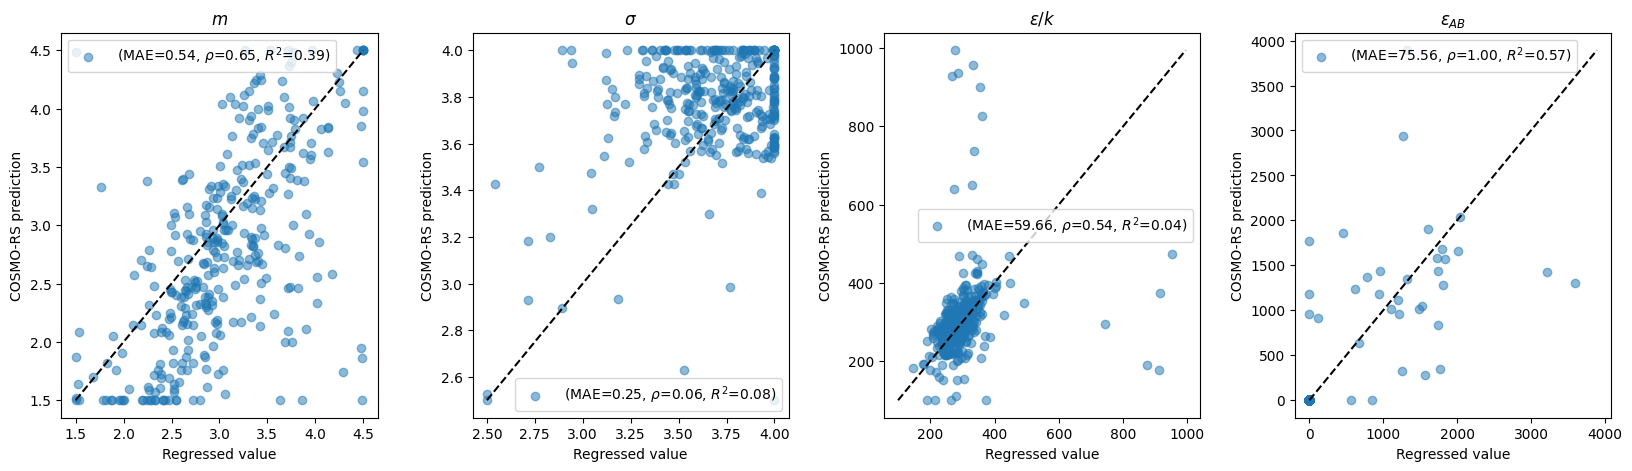

In [69]:

target_display_names = {
    "m": r"$m$",
    "sigma": r"$\sigma$",
    "epsilon_k": r"$\epsilon/k$",
    "mu": r"$\mu$",
    "KAB": r"$\kappa_{AB}$",
    "epsilonAB": r"$\epsilon_{AB}$",
}

cols = ["m", "sigma", "epsilon_k", "epsilonAB"]
n_rows = len(cols) // 2 + len(cols) % 2
# fig = plt.figure(figsize=(5 * n_rows, 5))
fig = plt.figure(figsize=(5*len(cols), 5))
fig.subplots_adjust(wspace=0.3)
for i, col in enumerate(cols):
    ax = fig.add_subplot(1, len(cols), i + 1)
    y = merged_df[f"{col}_regressed"].to_numpy()
    yhat = merged_df[f"{col}_cosmo"].to_numpy()
    current_scores = calculate_metrics(
        y, yhat, scores=["mae", "spearman", "r2"]
    )
    parity_plot(
        y,
        yhat,
        ax=ax,
        label="",
        scores=current_scores,
    )
    ax.set_xlabel("Regressed value")
    ax.set_ylabel("COSMO-RS prediction")
    ax.set_title(target_display_names.get(col, col))
fig.savefig("../data/08_reporting/cosmo_dortmund_parameter_correlations.png", dpi=300)

In [42]:
g = sns.FacetGrid(tips, col="time",  row="sex")
g.map(sns.scatterplot, "total_bill", "tip")

<module 'seaborn' from '/Users/Kobi/Library/Caches/pypoetry/virtualenvs/dl4thermo-gYF7kwgA-py3.8/lib/python3.8/site-packages/seaborn/__init__.py'>

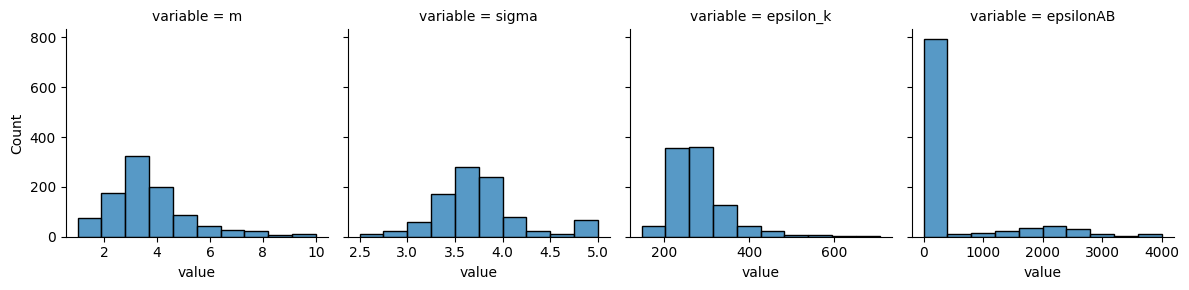

In [5]:
new_regressed = pd.melt(
    regressed_parameters, 
    id_vars="smiles_1", 
    value_vars=["m", "sigma", "epsilon_k", "epsilonAB"],
)
cols = ["smiles_1", "mean_residual", "mol_weight"]
new_regressed = new_regressed.merge(regressed_parameters[cols], on="smiles_1")
g = sns.FacetGrid(new_regressed, col="variable", sharex=False)
g.map(sns.histplot, "value", bins=10)

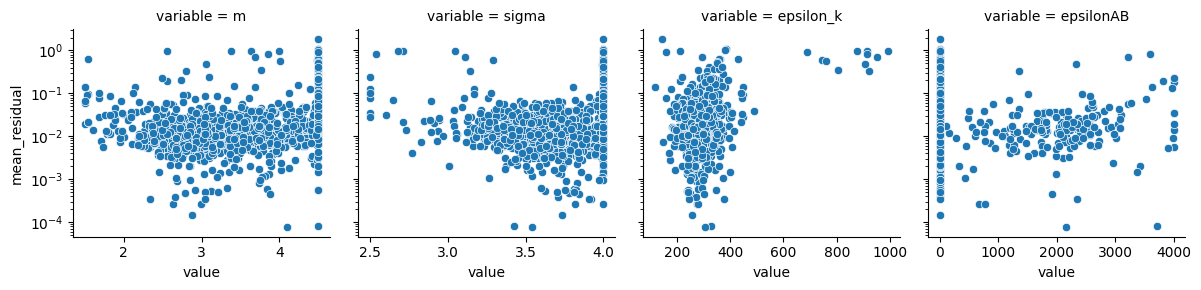

In [59]:
g = sns.FacetGrid(new_regressed, col="variable", sharex=False)
g.map(sns.scatterplot, "value","mean_residual").set(yscale="log")

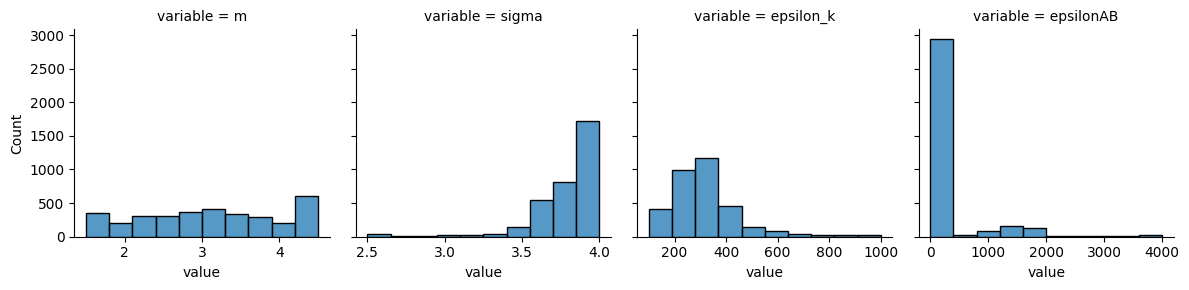

In [63]:
new_cosmo = pd.melt(
    cosmo_parameters, 
    id_vars="smiles", 
    value_vars=["m", "sigma", "epsilon_k", "epsilonAB"],
)
cols = ["smiles", "mean_residual"]
new_cosmo = new_cosmo.merge(cosmo_parameters[cols], on="smiles")
g = sns.FacetGrid(new_cosmo, col="variable", sharex=False)
g.map(sns.histplot, "value", bins=10)

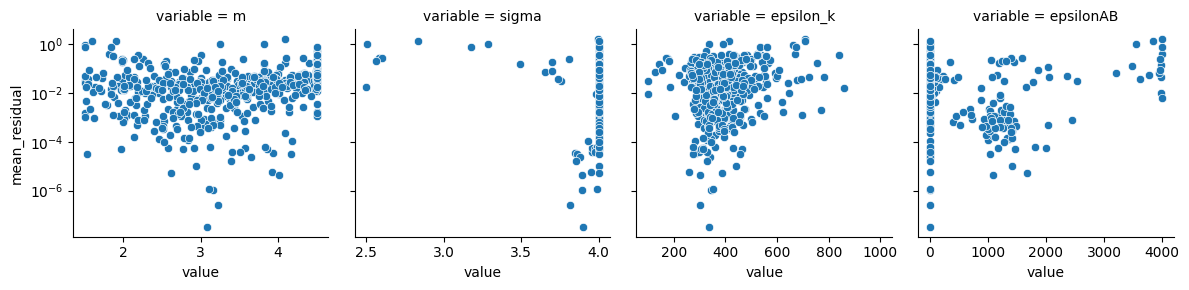

In [64]:
g = sns.FacetGrid(new_cosmo, col="variable", sharex=False)
g.map(sns.scatterplot, "value","mean_residual").set(yscale="log")

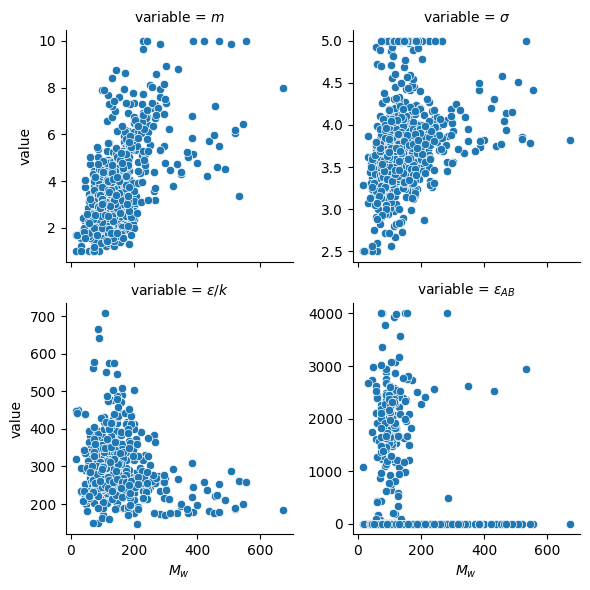

In [8]:
target_display_names = {
    "m": r"$m$",
    "sigma": r"$\sigma$",
    "epsilon_k": r"$\epsilon/k$",
    "mu": r"$\mu$",
    "KAB": r"$\kappa_{AB}$",
    "epsilonAB": r"$\epsilon_{AB}$",
    # "value": "Value",
}
display_regressed = new_regressed.replace(to_replace=target_display_names)
display_regressed = display_regressed.rename(columns={ "mol_weight": r"$M_w$"})
g = sns.FacetGrid(display_regressed, col="variable", col_wrap=2, sharey=False)
g.map(sns.scatterplot, r"$M_w$","value")
g.figure.savefig("../data/08_reporting/mw_pcsaft_parameter_correlation.png",dpi=300)
g.figure